# Science User Case - Inspecting a Candidate List

Ogle et al. (2016) mined the NASA/IPAC Extragalactic Database (NED) to identify a new type of galaxy: Superluminous Spiral Galaxies. Here's the paper:

Here's the paper: https://ui.adsabs.harvard.edu//#abs/2016ApJ...817..109O/abstract

Table 1 lists the positions of these Super Spirals. Based on those positions, let's create multiwavelength cutouts for each super spiral to see what is unique about this new class of objects.

## 1. Import some Python modules.

In [1]:
#Suppress unimportant warnings.
import warnings
warnings.filterwarnings("ignore")
#Add the workshop directory to your path.
import sys
sys.path.append('workshop-dev-master')

#Import the workshop utilities.
import navo_utils.utils
from navo_utils.image import Image, ImageColumn
from navo_utils.spectra import Spectra, SpectraColumn
from navo_utils.cone import Cone
from navo_utils.tap import Tap
#from navo_utils.utils import astropy_table_from_votable_response

#Import the astropy Table module.
from astropy.table import Table

## 2. Search NED for objects in this paper.

Insert a Code Cell below by clicking on the "Insert" Menu and choosing "Insert Cell Below". Then consult QuickReference.md to figure out how to use astroquery to search NED for all objects in a paper, based on the refcode of the paper. Inspect the resulting astropy table.

In [2]:
from astroquery.ned import Ned
objects_in_paper = Ned.query_refcode('2016ApJ...817..109O')
objects_in_paper.show_in_notebook()

idx,No.,Object Name,RA(deg),DEC(deg),Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,,degrees,degrees,,km / s,,,,arcm,,,,,,,
0,1,2MASX J00155012-1002427,3.95892,-10.045109999999999,G,52788.0,0.17608299999999999,,17.5g,--,10,0,51,6,4,10,0
1,2,2MASX J00380781-0109365,9.5325199999999999,-1.1602399999999999,G,62565.0,0.20869499999999999,,18.0g,--,10,0,59,8,4,10,0
2,3,2MASS J04042287-0541349,61.095480000000002,-5.6930300000000003,G,75138.0,0.250635,,18.6g,--,4,0,49,8,5,8,0
3,4,2MASX J07380615+2823592,114.52567999999999,28.39995,G,69255.0,0.23100999999999999,,18.0g,--,8,0,54,6,4,10,0
4,5,2MASX J07550424+1353261,118.76776,13.890650000000001,G,66754.0,0.22266900000000001,,18.5g,--,7,0,38,6,4,6,0
5,6,2MASX J08265512+1811476,126.72969000000001,18.196650000000002,G,79608.0,0.26554299999999997,,18.4g,--,4,0,34,5,4,6,0
6,7,2MASX J08542169+0449308,133.59032999999999,4.8251099999999996,G,47018.0,0.156835,,16.7g,--,12,0,58,7,4,10,0
7,8,WHL J090944.8+222607,137.4367,22.435390000000002,GClstr,90837.0,0.30299999999999999,PHOT,,--,4,0,0,2,4,0,0
8,9,2MASX J09094480+2226078,137.4367,22.435379999999999,G,85557.0,0.28538599999999997,,19.0g,--,5,0,30,4,5,6,0


## 3. Filter the NED results.

The results from NED will include galaxies, but also other kinds of objects. Print the 'Type' column to see the full range of classifications. Next, print the 'Type' of just the first source in the table, in order to determine its data type (since Python 3 distinguishes between strings and byte strings). Finally, use the data type information to filter the results so that we only keep the galaxies in the list.

In [3]:
objects_in_paper['Type']

G
G
G
G
G
G
G
GClstr
G
G
GClstr


In [4]:
#Let's see whether we are dealing with strings or byte strings
objects_in_paper[0]['Type']

b'G'

In [5]:
#Byte strings it is!
galaxies = objects_in_paper[objects_in_paper['Type'] == b'G']

galaxies.show_in_notebook()

idx,No.,Object Name,RA(deg),DEC(deg),Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,,degrees,degrees,,km / s,,,,arcm,,,,,,,
0,1,2MASX J00155012-1002427,3.95892,-10.045109999999999,G,52788.0,0.17608299999999999,,17.5g,--,10,0,51,6,4,10,0
1,2,2MASX J00380781-0109365,9.5325199999999999,-1.1602399999999999,G,62565.0,0.20869499999999999,,18.0g,--,10,0,59,8,4,10,0
2,3,2MASS J04042287-0541349,61.095480000000002,-5.6930300000000003,G,75138.0,0.250635,,18.6g,--,4,0,49,8,5,8,0
3,4,2MASX J07380615+2823592,114.52567999999999,28.39995,G,69255.0,0.23100999999999999,,18.0g,--,8,0,54,6,4,10,0
4,5,2MASX J07550424+1353261,118.76776,13.890650000000001,G,66754.0,0.22266900000000001,,18.5g,--,7,0,38,6,4,6,0
5,6,2MASX J08265512+1811476,126.72969000000001,18.196650000000002,G,79608.0,0.26554299999999997,,18.4g,--,4,0,34,5,4,6,0
6,7,2MASX J08542169+0449308,133.59032999999999,4.8251099999999996,G,47018.0,0.156835,,16.7g,--,12,0,58,7,4,10,0
7,9,2MASX J09094480+2226078,137.4367,22.435379999999999,G,85557.0,0.28538599999999997,,19.0g,--,5,0,30,4,5,6,0
8,10,2MASX J09260805+2405242,141.53357,24.090039999999998,G,66689.0,0.22245100000000001,,17.8g,--,10,0,32,5,6,6,0


## 4. Search the NAVO Registry for image resources.

The paper selected super spirals using WISE, SDSS, and GALEX images. Search the NAVO registry for all image resources, using the 'service_type' search parameter. How many image resources are currently available?

In [6]:
from navo_utils.registry import Registry

image_services = Registry.query(service_type='image')

print(f'{len(image_services)} result(s) found.')

image_services

305 result(s) found.


waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
str56,str16,str48,str7019,str227,str82,str60,str17
infrared#millimeter,PEP,ivo://irsa.ipac/herschel/images/pep,"The PACS Evolutionary Probe (PEP, Lutz et al. 2011) is a Herschel guaranteed time deep extragalactic survey (KPGT_dlutz_1) targeting six among the most popular ""blank fields"", ten lensing clusters of galaxies, and two z ~1 clusters at wavelengths of 100 and 160 microns. PEP includes SPIRE observations of the two z ~1 clusters at wavelengths of 250, 350, and 500 microns. SPIRE coverage of all other fields is available from the HerMES survey (Oliver et al. 2010). In addition, deep SPIRE GOODS-N data are provided by the GOODS-Herschel program (Elbaz et al. 2011).",https://irsa.ipac.caltech.edu/cgi-bin/Atlas/nph-atlas?mission=PEP&amp;hdr_location=%5CPEPDataPath%5C&amp;SIAP_ACTIVE=1&amp;collection_desc=PEP&amp;,https://irsa.ipac.caltech.edu/data/Herschel/PEP,NASA/IPAC Infrared Science Archive,simpleimageaccess
infrared#millimeter,VNGS,ivo://irsa.ipac/herschel/images/vngs,"The Very Nearby Galaxy Survey (VNGS) is a Herschel Key Program (KPGT_cwilso01_1) to measure the emission spectrum from dust as well as important cooling lines from the gaseous interstellar medium in a sample of 13 very nearby galaxies (M51, M81, NGC2403, NGC891, M83, M82, Arp220, NGC4038/39, NGC1068, NGC4151, CenA, NGC4125, and NGC205). These galaxies have been chosen to probe as wide a region in galaxy parameter space as possible while maximizing the achievable spatial resolution and are already well-studied from X-ray and optical through to radio wavelengths. The far-infrared and submillimeter wavelengths probed by Herschel are absolutely crucial for understanding the physical processes and properties of the interstellar medium, the interplay between star formation and the interstellar medium in galaxies, and how they may depend on the wider galaxian environment.",https://irsa.ipac.caltech.edu/cgi-bin/Atlas/nph-atlas?mission=VNGS&amp;hdr_location=%5CVNGSDataPath%5C&amp;SIAP_ACTIVE=1&amp;collection_desc=VNGS&amp;,https://irsa.ipac.caltech.edu/data/Herschel/VNGS,NASA/IPAC Infrared Science Archive,simpleimageaccess
infrared#millimeter,HerM33es,ivo://irsa.ipac/herschel/images/herm33es,Herschel PACS and SPIRE images of M33,https://irsa.ipac.caltech.edu/cgi-bin/Atlas/nph-atlas?mission=HerM33es&amp;hdr_location=%5CHerM33esDataPath%5C&amp;SIAP_ACTIVE=1&amp;collection_desc=HerM33es&amp;,https://irsa.ipac.caltech.edu/data/Herschel/HerM33es,NASA/IPAC Infrared Science Archive,simpleimageaccess
optical,DFBS,ivo://vopdc.obspm/dfbs,"The First Byurakan Survey (FBS) is the largest and the first systematic objective prism survey of the extragalactic sky. It covers 17,000 sq.deg. in the Northern sky together with a high galactic latitudes region in the Southern sky. The FBS has been carried out by B.E. Markarian, V.A. Lipovetski and J.A. Stepanian in 1965-1980 with the Byurakan Observatory 102/132/213 cm (40""/52""/84"") Schmidt telescope using 1.5 deg. prism. Each FBS plate contains low-dispersion spectra of some 15,000-20,000 objects; the whole survey consists of about 20,000,000 objects.",http://voparis-srv.obspm.fr/srv/sia-dfbs.php?,http://www.aras.am/Dfbs/dfbs.html,Paris Astronomical Data Centre,simpleimageaccess
optical,PTF Level 1,ivo://irsa.ipac/ptf/images/ptf_l1,"PTF is a fully-automated, wide-field survey aimed at a systematic exploration of the optical transient sky. Level 1 data are processed single exposure images.",https://irsa.ipac.caltech.edu/ibe/sia/ptf/images/level1?,https://irsa.ipac.caltech.edu/Missions/ptf.html,NASA/IPAC Infrared Science Archive,simpleimageaccess
optical,PTF Level 2,ivo://irsa.ipac/ptf/images/ptf_l2,"PTF is a fully-automated, wide-field survey aimed at a systematic exploration of the optical transient sky. Level 2 data are coadds of Level 1 images.",https://irsa.ipac.caltech.edu/ibe/sia/ptf/images/level2?,https://irsa.ipac.caltech.edu/Missions

## 5. Search the NAVO Registry for image resources that will allow you to search for AllWISE images.

There are hundreds of image resources...too many to quickly read through. Try adding the 'keyword' search parameter to your registry search, and find the image resource you would need to search the AllWISE images.

In [7]:
allwise_image_services = Registry.query(keyword='allwise', service_type='image')

print(f'{len(allwise_image_services)} result(s) found.')

allwise_image_services


1 result(s) found.


waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
str8,str11,str39,str1031,str60,str58,str34,str17
infrared,AllWISE L3a,ivo://irsa.ipac/wise/images/allwise/l3a,"The AllWISE program builds upon the work of the successful Wide-field Infrared Survey Explorer mission (WISE; Wright et al. 2010) by combining data from the WISE cryogenic and NEOWISE (Mainzer et al. 2011 ApJ, 731, 53) post-cryogenic survey phases to form the most comprehensive view of the full mid-infrared sky currently available. By combining the data from two complete sky coverage epochs using an advanced data processing system, AllWISE has generated new products that have enhanced photometric sensitivity and accuracy, and improved astrometric precision compared to the 2012 WISE All-Sky Data Release. Exploiting the 6 to 12 month baseline between the WISE sky coverage epochs enables AllWISE to measure source motions for the first time, and to compute improved flux variability statistics. The AllWISE Images Atlas is comprised of 18,240 4-band calibrated 1.56°x1.56° FITS images, depth-of-coverage and noise maps, and image metadata produced by coadding nearly 7.9 million Single-exposure images from all survey phases.",https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?,http://wise2.ipac.caltech.edu/docs/release/allwise/expsup/,NASA/IPAC Infrared Science Archive,simpleimageaccess


## 6. Choose the AllWISE image service that you are interested in.

In [8]:
allwise_image_service = allwise_image_services[0]
allwise_image_service

waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
str8,str11,str39,str1031,str60,str58,str34,str17
infrared,AllWISE L3a,ivo://irsa.ipac/wise/images/allwise/l3a,"The AllWISE program builds upon the work of the successful Wide-field Infrared Survey Explorer mission (WISE; Wright et al. 2010) by combining data from the WISE cryogenic and NEOWISE (Mainzer et al. 2011 ApJ, 731, 53) post-cryogenic survey phases to form the most comprehensive view of the full mid-infrared sky currently available. By combining the data from two complete sky coverage epochs using an advanced data processing system, AllWISE has generated new products that have enhanced photometric sensitivity and accuracy, and improved astrometric precision compared to the 2012 WISE All-Sky Data Release. Exploiting the 6 to 12 month baseline between the WISE sky coverage epochs enables AllWISE to measure source motions for the first time, and to compute improved flux variability statistics. The AllWISE Images Atlas is comprised of 18,240 4-band calibrated 1.56°x1.56° FITS images, depth-of-coverage and noise maps, and image metadata produced by coadding nearly 7.9 million Single-exposure images from all survey phases.",https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?,http://wise2.ipac.caltech.edu/docs/release/allwise/expsup/,NASA/IPAC Infrared Science Archive,simpleimageaccess


## 7. Choose one of the galaxies in the NED list.


In [9]:
from astropy.coordinates import SkyCoord
ra = 3.95892
dec = -10.045109999999999
pos = SkyCoord(ra, dec, unit = 'deg')

## 8. Search for a list of AllWISE images that cover this galaxy.

How many images are returned? Which are you most interested in?

In [10]:
from navo_utils.image import Image

#Doing an image query will return a list.
#Each element represents the search results for each position.
#If you enter only one position, there will be only one element in the list.
#Each element in the list can contain many images.

allwise_image_table=Image.query(service=allwise_image_service,coords=pos,radius=0)

## 9. How many images are returned for this one position? Which are you most interested in?

In [11]:
allwise_images = allwise_image_table[0]
allwise_images

sia_title,sia_url,sia_naxes,sia_fmt,sia_ra,sia_dec,sia_naxis,sia_crpix,sia_crval,sia_proj,sia_scale,sia_cd,sia_bp_id,sia_bp_ref,sia_bp_hi,sia_bp_lo,magzp,magzpunc,unc_url,cov_url,coadd_id
,,,,deg,deg,,pix,deg,,deg / pix,deg / pix,,,,,,,,,
str22,str110,int32,str10,float64,float64,object,object,object,str3,object,object,str2,float64,float64,float64,float64,float64,str113,str113,str13
W1 Coadd 0046m107_ac51,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w1-int-3.fits,2,image/fits,4.61538,-10.601111,[4095 4095],[2048.0 2048.0],[4.61538 -10.601111],SIN,[-0.0003819444391411 0.0003819444391411],[-0.0003819444391411 -0.0 -0.0 0.0003819444391411],W1,3.3500000000000001e-06,3.7799999999999998e-06,3.1300000000000001e-06,20.5,0.0060000000000000001,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w1-unc-3.fits.gz,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w1-cov-3.fits.gz,0046m107_ac51
W3 Coadd 0046m107_ac51,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w3-int-3.fits,2,image/fits,4.61538,-10.601111,[4095 4095],[2048.0 2048.0],[4.61538 -10.601111],SIN,[-0.0003819444391411 0.0003819444391411],[-0.0003819444391411 -0.0 -0.0 0.0003819444391411],W3,1.1559999999999999e-05,1.6269999999999998e-05,7.6000000000000001e-06,18.0,0.012,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w3-unc-3.fits.gz,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w3-cov-3.fits.gz,0046m107_ac51
W4 Coadd 0046m107_ac51,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w4-int-3.fits,2,image/fits,4.61538,-10.601111,[4095 4095],[2048.0 2048.0],[4.61538 -10.601111],SIN,[-0.0003819444391411 0.0003819444391411],[-0.0003819444391411 -0.0 -0.0 0.0003819444391411],W4,2.209e-05,2.336e-05,1.984e-05,13.0,0.012,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w4-unc-3.fits.gz,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w4-cov-3.fits.gz,0046m107_ac51
W2 Coadd 0046m107_ac51,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w2-int-3.fits,2,image/fits,4.61538,-10.601111,[4095 4095],[2048.0 2048.0],[4.61538 -10.601111],SIN,[-0.0003819444391411 0.0003819444391411],[-0.0003819444391411 -0.0 -0.0 0.0003819444391411],W2,4.6e-06,5.1900000000000003e-06,4.0199999999999996e-06,19.5,0.0070000000000000001,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w2-unc-3.fits.gz,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w2-cov-3.fits.gz,0046m107_ac51


## 10. Filter the list of returned AllWISE images so that you are left with only the images taken in band W1 (3.6 micron)

In [12]:
allwise_w1_images = allwise_images[allwise_images['sia_bp_id'] == 'W1']
allwise_w1_images

sia_title,sia_url,sia_naxes,sia_fmt,sia_ra,sia_dec,sia_naxis,sia_crpix,sia_crval,sia_proj,sia_scale,sia_cd,sia_bp_id,sia_bp_ref,sia_bp_hi,sia_bp_lo,magzp,magzpunc,unc_url,cov_url,coadd_id
,,,,deg,deg,,pix,deg,,deg / pix,deg / pix,,,,,,,,,
str22,str110,int32,str10,float64,float64,object,object,object,str3,object,object,str2,float64,float64,float64,float64,float64,str113,str113,str13
W1 Coadd 0046m107_ac51,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w1-int-3.fits,2,image/fits,4.61538,-10.601111,[4095 4095],[2048.0 2048.0],[4.61538 -10.601111],SIN,[-0.0003819444391411 0.0003819444391411],[-0.0003819444391411 -0.0 -0.0 0.0003819444391411],W1,3.3500000000000001e-06,3.7799999999999998e-06,3.1300000000000001e-06,20.5,0.0060000000000000001,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w1-unc-3.fits.gz,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w1-cov-3.fits.gz,0046m107_ac51


## 11. Visualize this AllWISE image.

In [13]:
allwise_w1_image = Image.get_fits(allwise_w1_images[0])

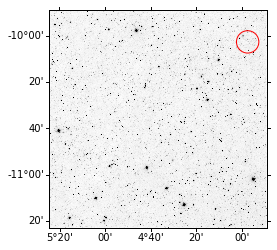

In [14]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
%matplotlib inline  

fig = plt.figure()

wcs = WCS(allwise_w1_image[0].header)
ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(allwise_w1_image[0].data, cmap='gray_r', origin='lower', vmax = 10)
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')

## 12. Plot a cutout of the AllWISE image, centered on your position.

Try a 60 arcsecond cutout.

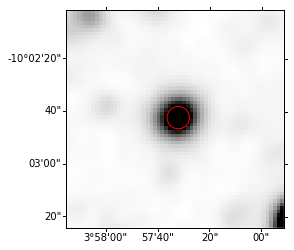

In [15]:
from astropy.nddata import Cutout2D

size = 60
cutout = Cutout2D(allwise_w1_image[0].data, pos, (size, size), wcs=wcs)
wcs = cutout.wcs

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(cutout.data, cmap='gray_r', origin='lower', vmax = 10)
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')


## 13. Try visualizing a cutout of a GALEX image that covers your position.

In [16]:
galex_image_services = Registry.query(keyword='galex', service_type='image', publisher = 'Space Telescope Science Institute')
#print(f'{len(galex_image_services)} result(s) found.')

galex_image_service = galex_image_services[0]
#galex_image_serviceservice,coords=pos,radius=0)

galex_image_table = Image.query(service=galex_image_service,coords=pos,radius=0)
galex_images = galex_image_table[0]
#galex_image_table[0]

galex_image_table[0]['contentType']
galex_fits_images = galex_images[galex_images['contentType'] == 'image/fits']
#galex_fits_images

galex_nuv_fits_images = galex_fits_images[galex_fits_images['enrValue']==2.35e-07]
#galex_nuv_fits_images

galex_nuv_fits_coadd = galex_nuv_fits_images[0]
#galex_nuv_fits_coadd

galex_nuv_image = Image.get_fits(galex_nuv_fits_coadd)

In [17]:
import numpy as np
image_data = galex_nuv_image[0].data
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: 0.0
Max: 7.18703
Mean: 0.00149343
Stdev: 0.0126399


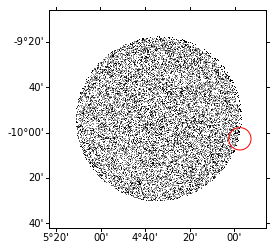

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=WCS(galex_nuv_image[0].header))
ax.imshow(galex_nuv_image[0].data, cmap='gray_r', origin='lower', vmin=0.0, vmax=0.01)
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')   

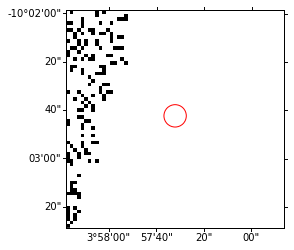

In [19]:
cutout = Cutout2D(galex_nuv_image[0].data, pos, size, wcs=WCS(galex_nuv_image[0].header))

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=cutout.wcs)
ax.imshow(cutout.data, cmap='gray_r', origin='lower', vmin = 0.0, vmax = 0.01)
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')


## 14. Try visualizing a cutout of an SDSS image that covers your position.

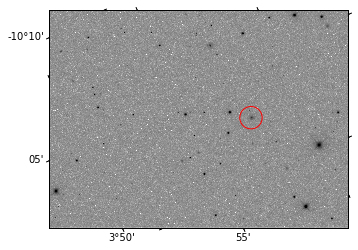

In [20]:
import astropy.visualization as vis

sdss_image_services = Registry.query(keyword='SDSS', service_type='image', publisher = 'The Johns Hopkins University')
sdss_image_service = sdss_image_services[2]
#sdss_image_service

sdss_image_table = Image.query(service=sdss_image_service,coords=pos,radius=0)
sdss_images = sdss_image_table[0]
#sdss_images

#sdss_image_table[0]['Title']
sdss_rband_images = sdss_images[sdss_images['Title'] == 'Sloan Digital Sky Survey - Filter r']
#sdss_rband_images[0]

sdss_rband_image = Image.get_fits(sdss_rband_images[0])

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=WCS(sdss_rband_image[0].header))

interval = vis.PercentileInterval(99.9)
vmin,vmax = interval.get_limits(sdss_rband_image[0].data)
norm = vis.ImageNormalize(vmin=vmin, vmax=vmax, stretch=vis.LogStretch(1000))
ax.imshow(sdss_rband_image[0].data, cmap = 'gray_r', norm = norm, origin = 'lower')          
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')

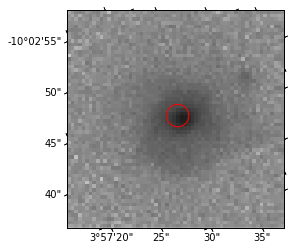

In [21]:
cutout = Cutout2D(sdss_rband_image[0].data, pos, size, wcs=WCS(sdss_rband_image[0].header))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=cutout.wcs)
vmin,vmax = interval.get_limits(sdss_rband_image[0].data)
norm = vis.ImageNormalize(vmin=vmin, vmax=vmax, stretch=vis.LogStretch(1000))
ax.imshow(cutout.data, cmap = 'gray_r', norm = norm, origin = 'lower')          
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')

In [22]:
sdss_image_services

waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
str7,str9,str38,str630,str105,str24,str28,str17
optical,SDSSDR2,ivo://sdss.jhu/services/siapdr2-images,"The Sloan Digital Sky Survey is a project to survey a 10000 square degree area on the Northern sky over a 5 year period. A dedicated 2.5m telescope is specially designed to take wide field (3 degrees in diameter) images using a 5x6 mosaic of 2048x2048 CCD`s, in five wavelength bands, operating in drift scan mode. The total raw data will exceed 40 TB. A processed subset, of about 1 TB in size, will consist of 1 million spectra, positions and image parameters for over 100 million objects, plus a mini-image centered on each object in every color. The data will be made available to the public after the completion of the survey",http://skyserver.sdss.org/vo/DR2SIAP/SIAP.asmx/getSiapInfo?&amp;FORMAT=image/fits&amp;BANDPASS=ugriz&amp;,http://www.sdss.jhu.edu/,The Johns Hopkins University,simpleimageaccess
optical,SDSSDR1,ivo://sdss.jhu/services/siapdr1-images,"The Sloan Digital Sky Survey is a project to survey a 10000 square degree area on the Northern sky over a 5 year period. A dedicated 2.5m telescope is specially designed to take wide field (3 degrees in diameter) images using a 5x6 mosaic of 2048x2048 CCD`s, in five wavelength bands, operating in drift scan mode. The total raw data will exceed 40 TB. A processed subset, of about 1 TB in size, will consist of 1 million spectra, positions and image parameters for over 100 million objects, plus a mini-image centered on each object in every color. The data will be made available to the public after the completion of the survey",http://skyserver.sdss.org/vo/DR1SIAP/SIAP.asmx/getSiapInfo?&amp;FORMAT=image/fits&amp;BANDPASS=ugriz&amp;,http://www.sdss.jhu.edu/,The Johns Hopkins University,simpleimageaccess
optical,SDSSDR7,ivo://sdss.jhu/services/siapdr7-images,"The Sloan Digital Sky Survey is a project to survey a 10000 square degree area on the Northern sky over a 5 year period. A dedicated 2.5m telescope is specially designed to take wide field (3 degrees in diameter) images using a 5x6 mosaic of 2048x2048 CCD`s, in five wavelength bands, operating in drift scan mode. The total raw data will exceed 40 TB. A processed subset, of about 1 TB in size, will consist of 1 million spectra, positions and image parameters for over 100 million objects, plus a mini-image centered on each object in every color. The data will be made available to the public after the completion of the survey",http://skyserver.sdss.org/vo/DR7SIAP/SIAP.asmx/getSiapInfo?&amp;FORMAT=image/fits&amp;BANDPASS=ugriz&amp;,http://www.sdss.jhu.edu/,The Johns Hopkins University,simpleimageaccess
optical,SDSSDR8,ivo://sdss.jhu/services/siapdr8-images,"The Sloan Digital Sky Survey is a project to survey a 10000 square degree area on the Northern sky over a 5 year period. A dedicated 2.5m telescope is specially designed to take wide field (3 degrees in diameter) images using a 5x6 mosaic of 2048x2048 CCD`s, in five wavelength bands, operating in drift scan mode. The total raw data will exceed 40 TB. A processed subset, of about 1 TB in size, will consist of 1 million spectra, positions and image parameters for over 100 million objects, plus a mini-image centered on each object in every color. The data will be made available to the public after the completion of the survey",http://skyserver.sdss.org/vo/DR8SIAP/SIAP.asmx/getSiapInfo?&amp;FORMAT=image/fits&amp;BANDPASS=ugriz&amp;,http://www.sdss.jhu.edu/,The Johns Hopkins University,simpleimageaccess
optical,SDSSDR9,ivo://sdss.jhu/services/siapdr9-images,"The Sloan Digital Sky Survey is a project to survey a 10000 square degree area on the Northern sky over a 5 year period. A dedicated 2.5m telescope is specially designed to take wide field (3 degrees in diameter) images using a 5x6 mosaic of 2048x2048 CCD`s, in five wavelength bands, operating in drift scan mode. The total raw data will exc

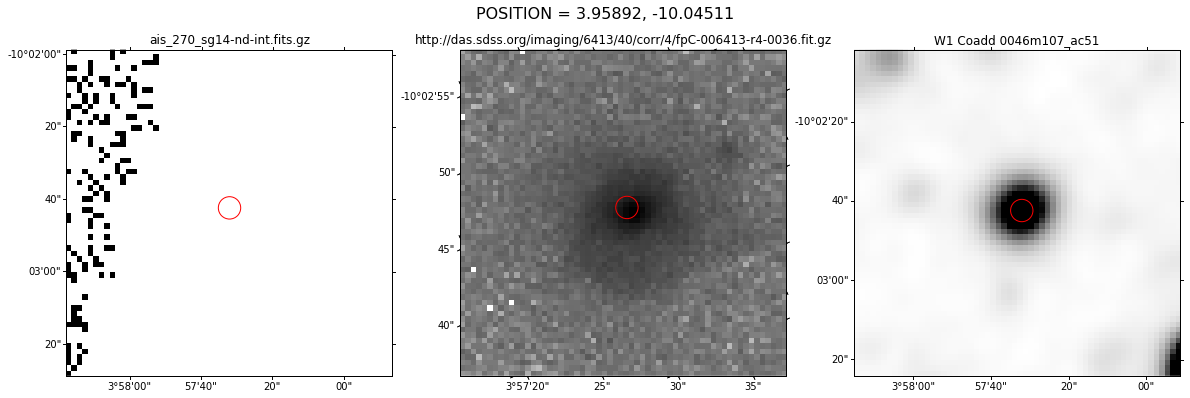

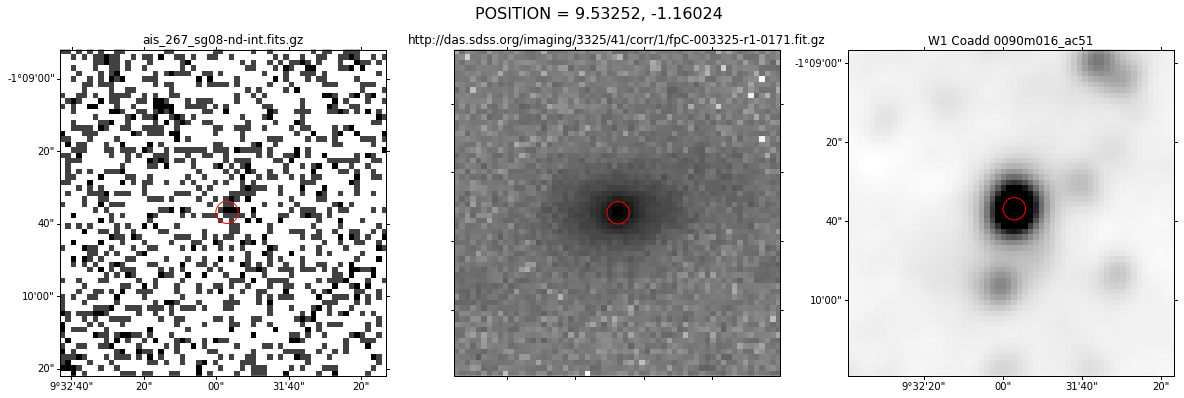

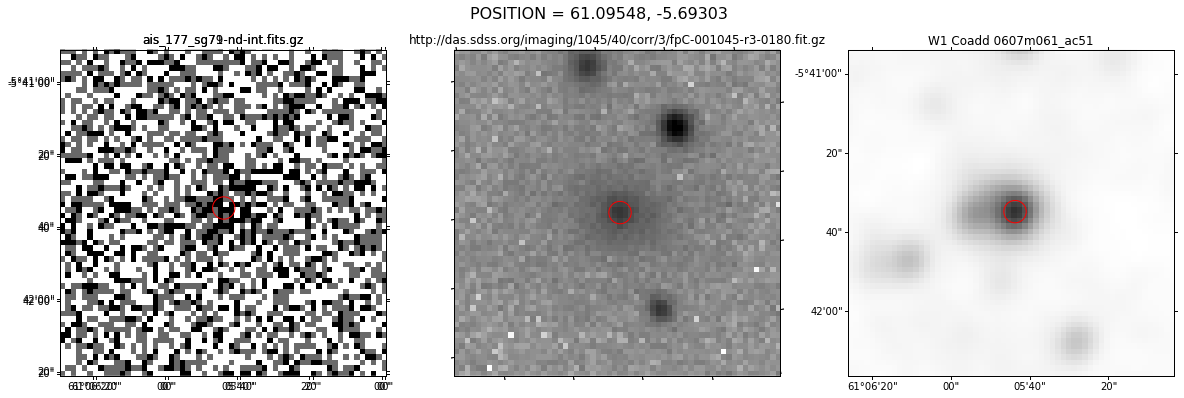

In [23]:
#Pick the first 3 galaxies.
galaxy_subset = galaxies[0:3]

#For each galaxy,
for galaxy in galaxy_subset:

    #Establish the position.
    ra = galaxy['RA(deg)']
    dec = galaxy['DEC(deg)']
    pos = SkyCoord(ra, dec, unit = 'deg')    
    
    #Set up the plot for this position.
    fig = plt.figure(figsize=(20,6))
    plt.suptitle('POSITION = ' + str(ra) + ', ' + str(dec), fontsize=16)

    #GALEX
    
    #Find the GALEX images that overlap the position.
    galex_image_table = Image.query(service=galex_image_service,coords=pos,radius=0)
    galex_images = galex_image_table[0]
    
    #Find the GALEX All-Sky Image Survey (AIS) Near-UV FITS coadd. 
    for galex_image in galex_images:
        if (galex_image['contentType'] == 'image/fits') and galex_image['enrValue']==2.35e-07 and 'AIS' in galex_image['accessURL'] and 'main' in galex_image['accessURL']:
 
            #Create a cutout.
            gimage = Image.get_fits(galex_image)
            galex_cutout = Cutout2D(gimage[0].data, pos, size, wcs=WCS(gimage[0].header))
            
            #Plot the cutout in the first position of a 1x3 (rowsxcols) grid.
            ax = fig.add_subplot(1, 3, 1, projection=galex_cutout.wcs)
            ax.set_title(galex_image['name'])
            ax.imshow(galex_cutout.data, cmap='gray_r', origin='lower', vmin = 0.0, vmax = 0.01)
            ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')

    #SDSS
    
    #Find the SDSS images that overlap the position.
    sdss_image_table = Image.query(service=sdss_image_service,coords=pos,radius=0)
    sdss_images = sdss_image_table[0]
    
    #Find the SDSS r-band image.
    sdss_rband_images = sdss_images[sdss_images['Title'] == 'Sloan Digital Sky Survey - Filter r']
    sdss_rband_image = Image.get_fits(sdss_rband_images[0])
    
    #Create a cutout.
    sdss_rband_image = Image.get_fits(sdss_rband_images[0])
    sdss_cutout = Cutout2D(sdss_rband_image[0].data, pos, size, wcs=WCS(sdss_rband_image[0].header))
    
    #Plot the cutout in the second position of a 1x3 grid.
    vmin,vmax = interval.get_limits(sdss_cutout.data)
    norm = vis.ImageNormalize(vmin=vmin, vmax=vmax, stretch=vis.LogStretch(1000))
    ax = fig.add_subplot(1, 3, 2, projection=sdss_cutout.wcs)
    ax.imshow(sdss_cutout.data, cmap = 'gray_r', norm = norm, origin = 'lower')          
    ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')
    ax.set_title(sdss_rband_images[0]['url'])
    
    #AllWISE
    
    #Find the AllWISE images that overlap the position.
    allwise_image_table=Image.query(service=allwise_image_service,coords=pos,radius=0)
    allwise_images = allwise_image_table[0]
    
    #Find the AllWISE W1 channel images.
    allwise_w1_images = allwise_images[allwise_images['sia_bp_id'] == 'W1']
    
    #Create a cutout.
    allwise_w1_image = Image.get_fits(allwise_w1_images[0])
    allwise_cutout = Cutout2D(allwise_w1_image[0].data, pos, (size, size), wcs=WCS(allwise_w1_image[0].header))

    #Plot the cutout in the third position of a 1x3 grid.
    ax = fig.add_subplot(1, 3, 3, projection=allwise_cutout.wcs)
    ax.imshow(allwise_cutout.data, cmap='gray_r', origin='lower', vmax = 10)
    ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')
    ax.set_title(allwise_w1_images[0]['sia_title'])
